# Batimetría de expansión del fondo marino y anomalías magnéticas

Benjamín Aguilar

Diego Céspedes


## Setup
Carguemos las librerías que utilizaremos durante la clase

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cartopy import config
import cartopy.crs as ccrs
from scipy import signal

## Geología Marina, batimetría y anomalías magnéticas

Veremos el magnetismo marino y los datos de batimetría de dos estudios, de la dorsal mesoatlántica y la dorsal del Pacífico Oriental.

Primero cargaremos los datos del Atlántico (a los que se puede acceder aquí: https://maps.ngdc.noaa.gov/viewers/geophysics/), para luego filtrar la información que nos será útil.

In [2]:
# Load the seafloor depth, marine mag anom data
#columns ['SURVEY_ID','TIMEZONE','DATE','TIME','LAT','LON','POS_TYPE','NAV_QUALCO','BAT_TTIME','CORR_DEPTH','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID']

vanc05mv_data_file = pd.read_table('data_tracks/vanc05mv.m77t')
atlantic_data = vanc05mv_data_file.drop(columns=['SURVEY_ID','TIMEZONE','DATE','TIME','POS_TYPE','NAV_QUALCO',
                                                 'BAT_TTIME','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT2','MAG_RES',
                                                 'MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS',
                                                 'FREEAIR','GRA_QUALCO','LINEID','POINTID'])
atlantic_data.head()

,LAT,LON,CORR_DEPTH,MAG_TOT
0,-33.03604,-71.62559,NaN,NaN
1,-33.03604,-71.62559,NaN,NaN
2,-33.03604,-71.62559,NaN,NaN
3,-33.03604,-71.62559,NaN,NaN
4,-33.03604,-71.62559,NaN,NaN


In [3]:
atlantic_data.describe()

,LAT,LON,CORR_DEPTH,MAG_TOT
count,26951.000000,26951.000000,25010.000000,14028.000000
mean,-47.071392,-36.939197,3018.086765,26557.261762
std,6.643869,32.681119,1446.118658,1157.487595
min,-56.018980,-76.166600,76.000000,24852.000000
25%,-52.042025,-72.776660,1764.000000,25434.000000
50%,-49.004340,-40.010090,3267.500000,26358.000000
75%,-41.646480,-6.273700,4248.000000,27472.000000
max,-32.989350,18.437850,5370.000000,29206.000000


Usaremos el condicional ``~np.isnan`` para seleccionar filas donde tenemos medidas de profundidad y campo magnético.

In [4]:
atlantic_data_clean = atlantic_data[~np.isnan(atlantic_data['CORR_DEPTH']) &  ~np.isnan(atlantic_data['MAG_TOT'])];
atlantic_data_clean.head()

,LAT,LON,CORR_DEPTH,MAG_TOT
11204,-53.15271,-51.62174,2376.0,29206.0
11205,-53.15178,-51.61709,2394.0,29206.0
11206,-53.15079,-51.61217,2373.0,29205.0
11207,-53.14974,-51.60716,2358.0,29204.0
11208,-53.14873,-51.60215,2332.0,29203.0


In [5]:
atlantic_data_clean.describe()

,LAT,LON,CORR_DEPTH,MAG_TOT
count,14027.000000,14027.000000,14027.000000,14027.00000
mean,-47.720326,-16.801461,3928.335638,26557.35282
std,4.564983,19.269079,794.104704,1157.47861
min,-53.152710,-51.621740,1625.000000,24852.00000
25%,-51.648660,-33.622330,3393.000000,25434.00000
50%,-49.378000,-15.446450,4028.000000,26358.00000
75%,-44.288285,0.384325,4515.000000,27472.00000
max,-37.232890,13.553150,5370.000000,29206.00000


¡Echemos un vistazo a nuestros datos! Grafique ``atlantic_data`` en un mapa y haga que tenga un ancho de línea de 2 y un color naranja. También trace ``atlantic_data_clean`` en el mismo mapa y haga que tenga un ancho de línea de 4 y un color rojo.

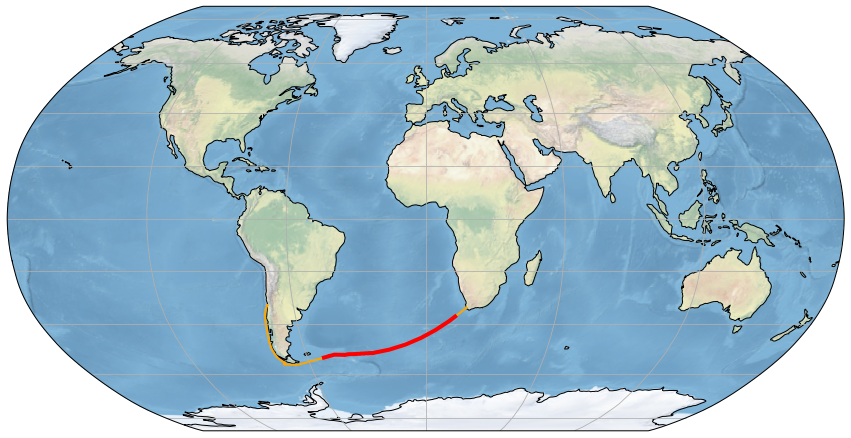

In [6]:
plt.figure(1,(15,15))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

ax.plot(atlantic_data['LON'],atlantic_data['LAT'],'-',
            color='orange',linewidth=2,transform=ccrs.PlateCarree())
ax.plot(atlantic_data_clean['LON'],atlantic_data_clean['LAT'],'-',
            color='red',linewidth=4,transform=ccrs.PlateCarree()) # Plotee aqui los datos filtados
ax.coastlines()
ax.stock_img()
ax.gridlines()

plt.show()

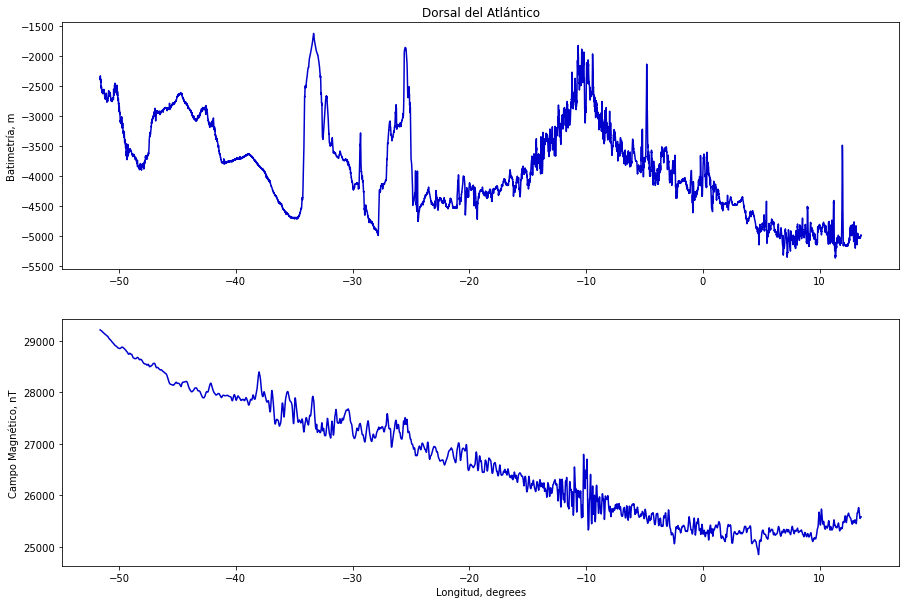

In [7]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(atlantic_data_clean['LON'],-1*atlantic_data_clean['CORR_DEPTH'],color='mediumblue');
ax1.set_ylabel('Batimetría, m');
ax1.set_title('Dorsal del Atlántico')

ax2=plt.subplot(2, 1, 2)
ax2.plot(atlantic_data_clean['LON'],atlantic_data_clean['MAG_TOT'],color='mediumblue');
ax2.set_xlabel('Longitud, degrees');
ax2.set_ylabel('Campo Magnético, nT');

Analicemos solo la parte del levantamiento alrededor de la dorsal, para ser más exactos entre las longitudes -24.0º - 0.0º. Para hacer esto use la una condición booleana para extraer las filas de ``atlantic_data_clean`` donde ``atlantic_data_clean['LON']`` está entre esos valores.

In [8]:
atlantic_data_cropped = atlantic_data_clean[(atlantic_data_clean['LON']<=0) & (atlantic_data_clean['LON']>=-24.0)]

Aquí hay un mapa donde nuestra por donde el barco midió la batimetría del oceáno. En el fondo de la figura se puede ver la batimetría de todo el oceáno.
![](MAR_track_map.png)

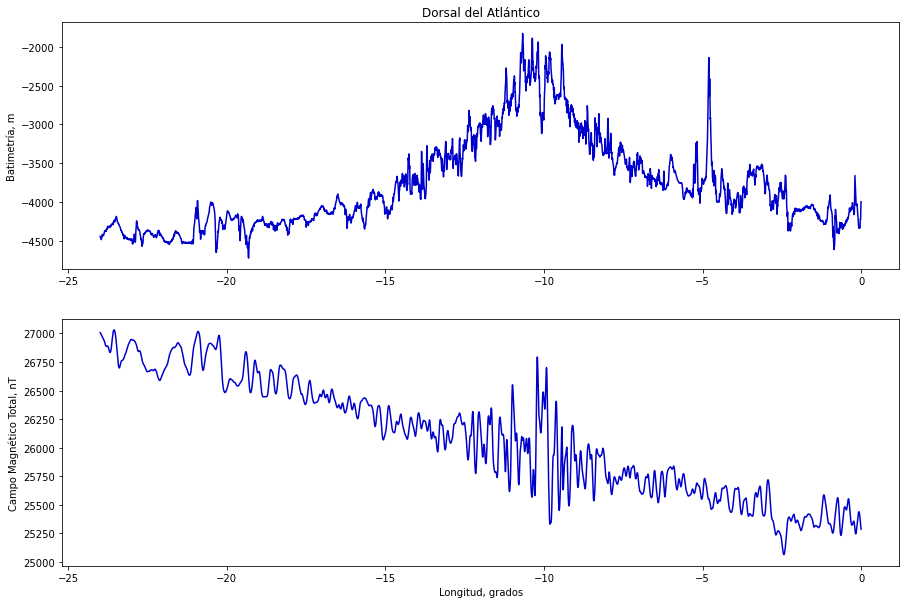

In [9]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(atlantic_data_cropped['LON'],-1*atlantic_data_cropped['CORR_DEPTH'],color='mediumblue');
ax1.set_ylabel('Batimetría, m');
ax1.set_title('Dorsal del Atlántico')

ax2=plt.subplot(2, 1, 2)
ax2.plot(atlantic_data_cropped['LON'],atlantic_data_cropped['MAG_TOT'],color='mediumblue');
ax2.set_xlabel('Longitud, grados');
ax2.set_ylabel('Campo Magnético Total, nT');

Usé otro programa para proyectar las coordenadas de latitud y longitud en distacia. Para así poder observar los datos usando como origen la dorsal del Atlántico. Carguemos esos nuevos datos.

In [10]:
projected_atlantic_data = pd.read_csv('data_tracks/projected_vanc05mv.csv',names=['DIST','DEPTH','MAG_TOT'])

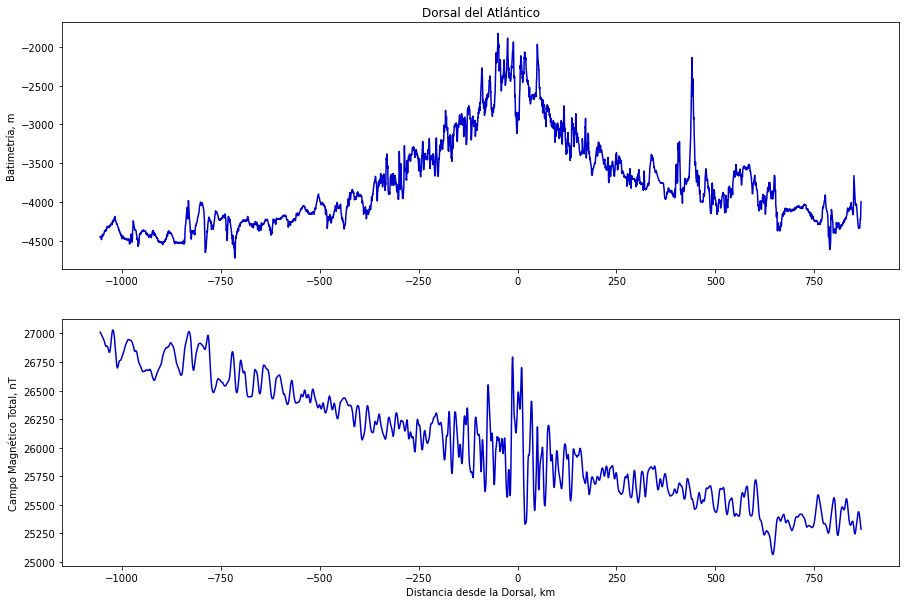

In [11]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(projected_atlantic_data['DIST'],-1*projected_atlantic_data['DEPTH'],color='mediumblue');
ax1.set_title('Dorsal del Atlántico')
ax1.set_ylabel('Batimetría, m');

ax2=plt.subplot(2, 1, 2)
ax2.plot(projected_atlantic_data['DIST'],projected_atlantic_data['MAG_TOT'],color='mediumblue');
ax2.set_xlabel('Distancia desde la Dorsal, km');
ax2.set_ylabel('Campo Magnético Total, nT');

Ahora carguemos y filtremos los datos de la dorsal del Pacífico (https://catalog.data.gov/dataset/multibeam-collection-for-nbp9707-multibeam-data-collected-aboard-nathaniel-b-palmer-from-1997-1). Esta vez seleccionaremos las longitudes entre -126º y -95º.

In [12]:
# Load the seafloor depth, marine mag anom data
# Source: https://maps.ngdc.noaa.gov/viewers/geophysics/
#names=['SURVEY_ID','TIMEZONE','DATE','TIME','LAT','LON','POS_TYPE','NAV_QUALCO','BAT_TTIME','CORR_DEPTH','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID'])

nbp9707_data_file=pd.read_table('data_tracks/nbp9707.m77t')
pacific_data = nbp9707_data_file.drop(columns=['SURVEY_ID','TIMEZONE','DATE','TIME','POS_TYPE','NAV_QUALCO','BAT_TTIME','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID'])
pacific_data.head()
pacific_data_clean =  pacific_data[~np.isnan(pacific_data['MAG_TOT'])&~np.isnan(pacific_data['CORR_DEPTH'])&~np.isnan(pacific_data['LON'])&~np.isnan(pacific_data['LAT'])]#use ~np.isnan para limpiar los datos nan
pacific_data_cropped = pacific_data_clean[(pacific_data_clean['LON']>=-126)&(pacific_data_clean['LON']<=-95)]# use una condición boolenana para filtrar los datos entre -126º a -95º

Nuevamente, aquí hay un mapa donde se muestra por donde el barco midió la batimetría del oceáno Pacífico. En el fondo de la figura se puede ver la batimetría de todo el oceáno.
![](EPR_track_map.png)

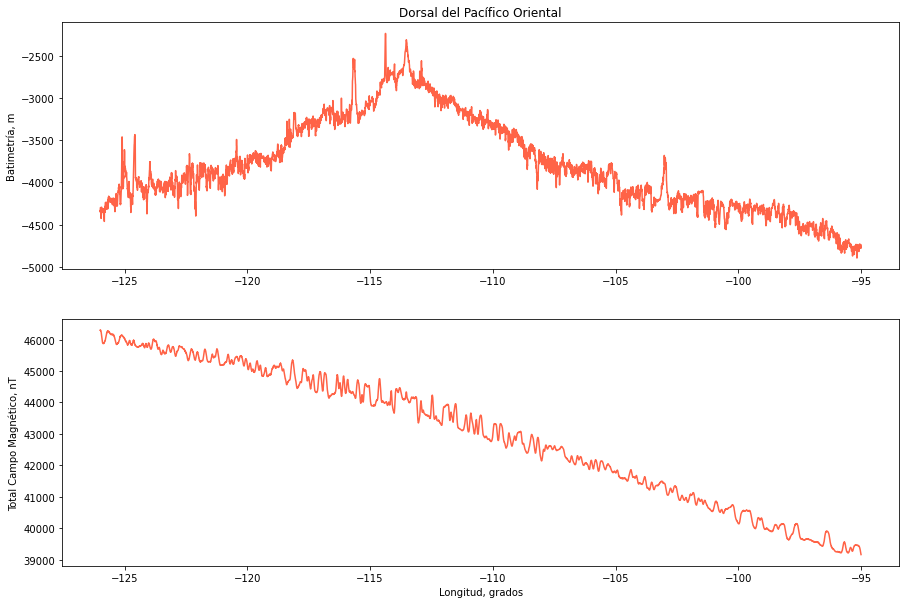

In [13]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(pacific_data_cropped['LON'],-1*pacific_data_cropped['CORR_DEPTH'],color='tomato');
ax1.set_ylabel('Batimetría, m');
ax1.set_title('Dorsal del Pacífico Oriental')

ax2=plt.subplot(2, 1, 2)
ax2.plot(pacific_data_cropped['LON'],pacific_data_cropped['MAG_TOT'],color='tomato');
ax2.set_xlabel('Longitud, grados');
ax2.set_ylabel('Total Campo Magnético, nT');

Nuevamente, utilicé el software GMT (herramientas de mapeo genérico) para proyectar las coordenadas de latitud y longitud sobre la distancia desde la dorsal.

In [14]:
projected_pacific_data = pd.read_csv('data_tracks/projected_nbp9707.csv',names=['DIST','DEPTH','MAG_TOT'])

## Batimetría
Ahora comparemos la batimetría de las dos dorsales. Plotiemos ambas batimetrías en una figura con dos subplots. Use $\pm$ 1000 km como límites del eje x y de -5000 a -1500 metros como límites del eje y para ambas dorsales.

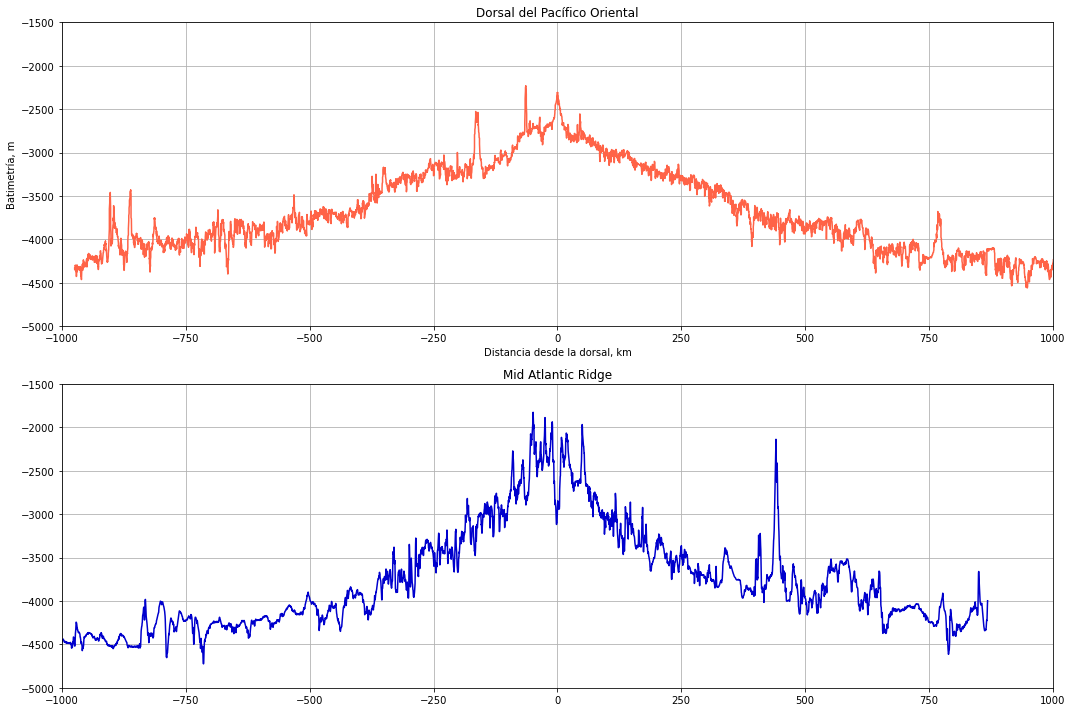

In [15]:
plt.figure(1,(15,10))
ax1 = plt.subplot(2,1,1)
ax1.plot(projected_pacific_data['DIST'],-projected_pacific_data['DEPTH'],color='tomato') # plot the pacific bathymetry
ax1.set_xlim(-1000, 1000) # set the x axis range
ax1.set_ylim(-5000, -1500) # set the y  axis range
ax1.set_xlabel('Distancia desde la dorsal, km') # labels!
ax1.set_ylabel('Batimetría, m')
ax1.set_title('Dorsal del Pacífico Oriental')
ax1.grid()

ax2 = plt.subplot(2,1,2)
ax2.plot(projected_atlantic_data['DIST'],-projected_atlantic_data['DEPTH'],color='mediumblue'); # plot the atlantic bathymetry
ax2.set_xlim(-1000, 1000)
ax2.set_ylim(-5000, -1500)
ax1.set_xlabel('Distancia desde la dorsal, km') # labels!
ax1.set_ylabel('Batimetría, m')
ax2.set_title('Mid Atlantic Ridge')
ax2.grid()

plt.tight_layout()

![](spreading_ridges.png)


¿Qué observas en la batimetría? ¿Tienen estas dorsales un valle de rift en el centro? ¿La pendiente es empinada o más bien plana? ¿La batimetría es rugosa o suave?

Si observamos el grafico, podremos ver que el grafico de las profundidades con respecto a las dorsales se asimila a uno simetrico con eje de simetris en las dorsales. Por otro lado si vemos mas a fondo el grafico, notaremos que en el caso del oceano atlantico existe un vaye de rift en la zona central de su dorsal, al contrario del pacifico en donde se puede identificar algo mas parecido a un 'swell'. Ahora si analizamos las pendientes de ambos graifcos, podemos notar que en el caso del dorsal del oceano pacifico tiene una pendiente mas suave y emnos inclinada en comparacion a la del oceano atlantico la cual tiene una pendiente empinada.

Según la batimetría de la dorsal, ¿qué centro de expansión crees que se está extendiendo más rápido el Atlántico (azul) o el Pacífico (rojo)?

Si comparamos las caracteristacas descritas en la pregunta anterior junto con los graficos obtenidos, con la informacion presenta en la infografia de la batimetria, podremos notar que el Pacifico se esta extendiendo a una mas rapido que el Atlantico.


## Campo magnético de la corteza
Ahora comparemos sus datos de campo magnético marino.

Haz un gráfico del campo magnético de cada dorsal (['MAG_TOT']). Siga el código anterior para la batimetría. Asegúrese de incluir etiquetas de eje.

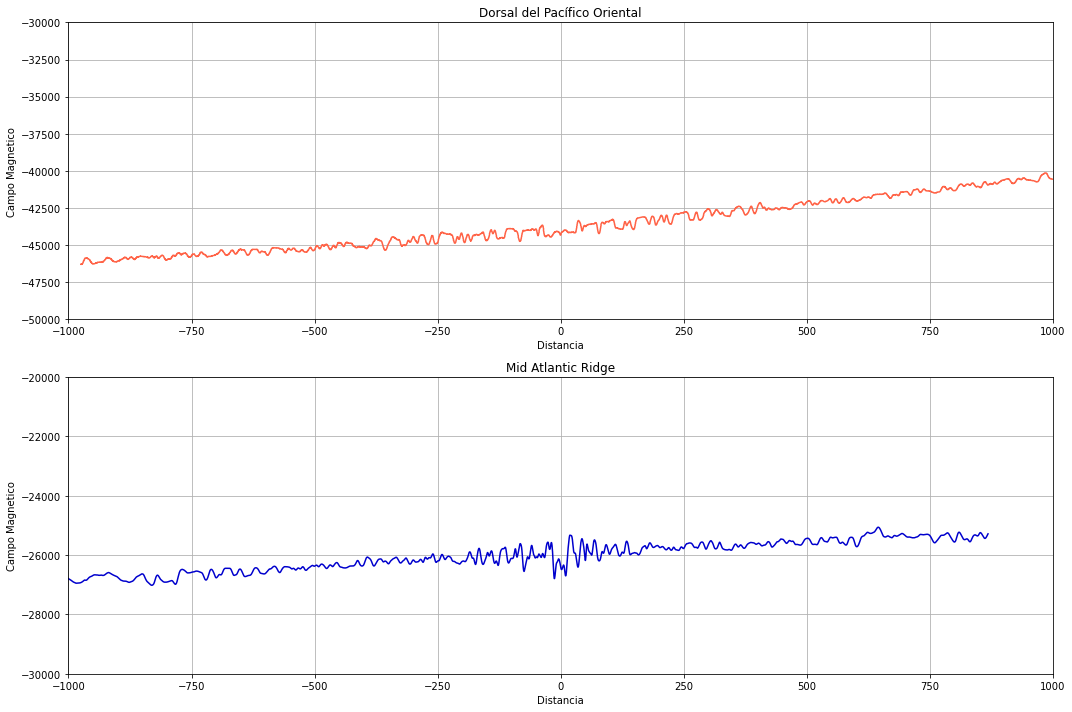

In [42]:
# Plotee el campo magnético (siga el ejemplo anterior)
plt.figure(1,(15,10))
ax1 = plt.subplot(2,1,1)
ax1.plot(projected_pacific_data['DIST'],-projected_pacific_data['MAG_TOT'],color='tomato') # plotear intensidad del campo magnetico en el pacífico
ax1.set_xlim(-1000, 1000) # set the x axis range
ax1.set_ylim(-50000, -30000) # set the y  axis range
ax1.set_xlabel('Distancia') # labels!
ax1.set_ylabel('Campo Magnetico')
ax1.set_title('Dorsal del Pacífico Oriental')
ax1.grid()

ax2 = plt.subplot(2,1,2)
ax2.plot(projected_atlantic_data['DIST'],-projected_atlantic_data['MAG_TOT'],color='mediumblue'); # plotear intensidad del campo magnetico en el atlantico
ax2.set_xlim(-1000, 1000);
ax2.set_ylim(-30000, -20000);
ax2.set_xlabel('Distancia'); # labels!
ax2.set_ylabel('Campo Magnetico')
ax2.set_title('Mid Atlantic Ridge')
ax2.grid()

plt.tight_layout()

Para entender mejor el campo magnético he definido una nueva función ``total2anom`` . El magnetómetro mide el campo magnético total (incluyendo el terrestre) y es necesario remover esa componente de los datos para obtener sólo en campo magnético del fondo marino (anomalía magnética). La función ``total2anom`` filtra ese campo magnético extra presente en los datos.

In [31]:
def total_to_anomaly(total_mag, distance):
    """
    Simple function (i.e. too simple as it doesn't use knowledge of background field from observatory) to process 
    measured total magnetic field to magnetic anomaly. Detrends and highpass filters the total field.
    
    parameters
    ----------
    total_mag : total magnetic field measurement
    distance : distance from the ridge in km
    
    output
    ------
    filtered_anom : marine magnetic anomaly (detrended and filtered total field)
    """
    total_detrended = signal.detrend(total_mag); # detrend to remove drift
    sample_dist = np.mean(abs(distance.values[1:]-distance.values[0:-1])); # determine sample spacing
    fs = 1/sample_dist; # sampling frequency in km^-1
    fN = fs *0.5; # Nyquist frequency
    # design filter coefficents for highpass filter - 0 to 1/500km filtered, 1/450km to fN passed, 
    # remove nonlinear drift
    filter_coefs = signal.remez(1001, [0, 0.002, 0.00222, fN], [0, 1], fs=fs);
    # apply the filter to the detrended anomaly
    filtered_anom = signal.filtfilt(filter_coefs, [1], total_detrended, padlen=len(total_detrended)-1)
    
    return filtered_anom

Utilice esta función ``total_to_anomaly`` para calcular las anomalías magnéticas marinas.

In [28]:
atl_mma = total_to_anomaly(projected_atlantic_data['MAG_TOT'],projected_atlantic_data['DIST'])
pac_mma = total_to_anomaly(projected_pacific_data['MAG_TOT'],projected_pacific_data['DIST'])

Tracemos estos datos

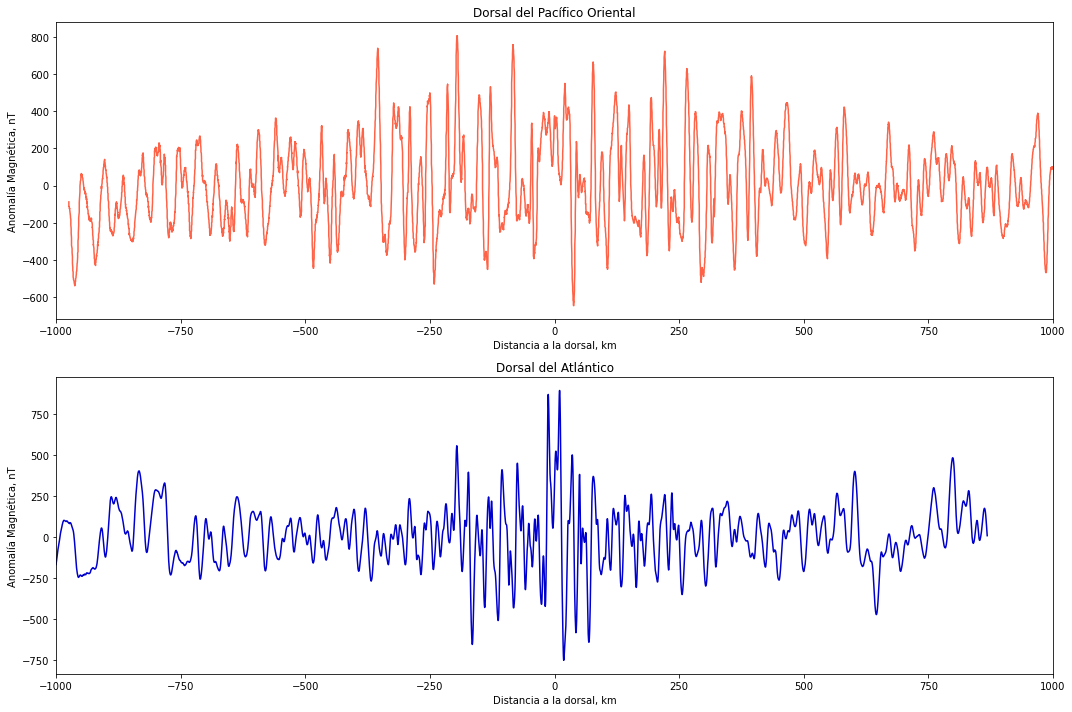

In [43]:
plt.figure(1,(15,10))
ax1 = plt.subplot(2,1,1)
ax1.plot(projected_pacific_data['DIST'],pac_mma,color='tomato'); # plot the pacific marine magnetic anomaly
ax1.set_xlim(-1000, 1000);
ax1.set_xlabel('Distancia a la dorsal, km');
ax1.set_ylabel('Anomalía Magnética, nT');
ax1.set_title('Dorsal del Pacífico Oriental');

ax2 = plt.subplot(2,1,2)
ax2.plot(projected_atlantic_data['DIST'],atl_mma,color='mediumblue'); # plot the atlantic marine magnetic anomaly
ax2.set_xlim(-1000, 1000);
ax2.set_xlabel('Distancia a la dorsal, km');
ax2.set_ylabel('Anomalía Magnética, nT');
ax2.set_title('Dorsal del Atlántico');

plt.tight_layout()

Plotee las anomalías magnéticas marinas un figura con dos subplots usando como referencia el 0 nT, y amplíe el xlim a $\pm$ 100 km y agregue una cuadrícula con xticks cada 10 km usando ``ax1.set_xticks(np.arange(-100,100,10))``.

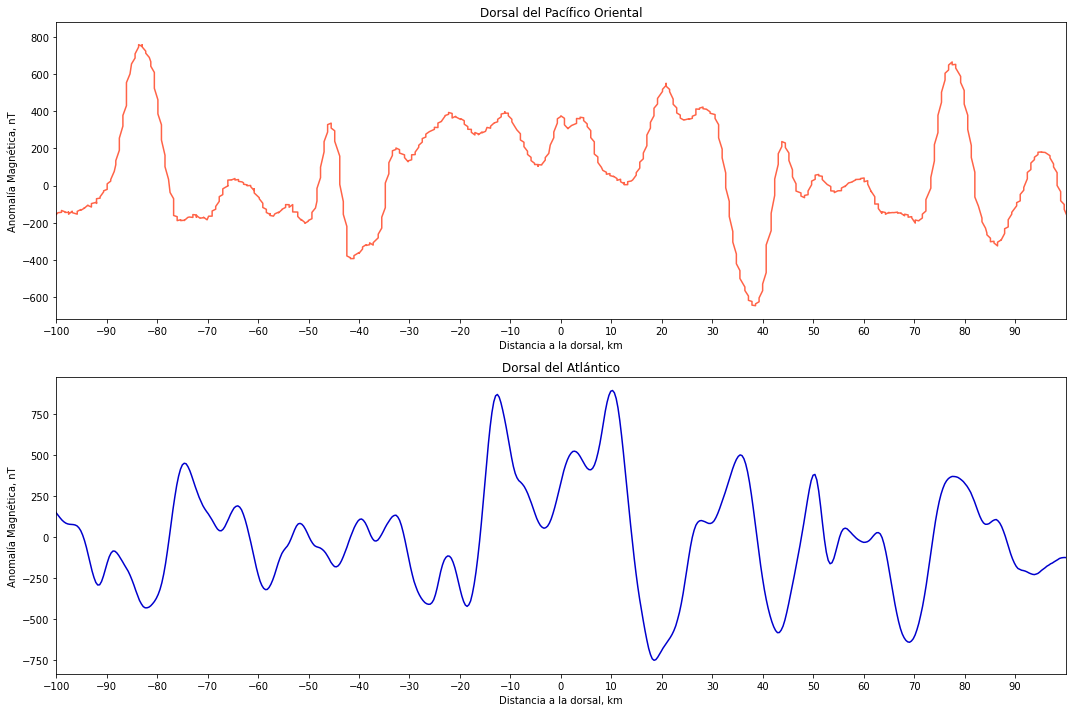

In [44]:
plt.figure(1,(15,10))

ax1 = plt.subplot(2,1,1)
ax1.set_xticks(np.arange(-100,100,10))
ax1.plot(projected_pacific_data['DIST'],pac_mma,color='tomato'); # plot the pacific marine magnetic anomaly
ax1.set_xlim(-100, 100);
ax1.set_xlabel('Distancia a la dorsal, km');
ax1.set_ylabel('Anomalía Magnética, nT');
ax1.set_title('Dorsal del Pacífico Oriental');

ax2 = plt.subplot(2,1,2)
ax2.set_xticks(np.arange(-100,100,10))
ax2.plot(projected_atlantic_data['DIST'],atl_mma,color='mediumblue'); # plot the atlantic marine magnetic anomaly
ax2.set_xlim(-100, 100);
ax2.set_xlabel('Distancia a la dorsal, km');
ax2.set_ylabel('Anomalía Magnética, nT');
ax2.set_title('Dorsal del Atlántico');

plt.tight_layout()

![](marine_mag_anom.png)

¿Pueden hacer coincidir las GPTS (mostradas anteriormente) y las anomalías magnéticas en el oceáno? ¿Puedes identificar las crónicas de polaridad de Bruhnes, Matuyama, Gauss y Gilbet? ¿A qué distancia de las dorales se produce la inversión Bruhnes-Matuyama (que fue hace 776.000 años)?

Si, podemos encontrar patrones similares entre los gráficos obtenidos y el modelo entregado, siendo más notoria la similitud entre el modelo y el grafico del océano atlántico que entre el modelo y el grafico del océano pacifico. No, ya que nuestros gráficos abordan una distancia de 100 kilómetros para cada lado, según lo entregado en el modelo y lo observado en el grafico, solo se alcanza a distinguir las crónicas de polaridad de Bruhnes y Matuyama. Para el grafico del Atlántico la podemos identificar a 20km aproximadamente del dorsal y en el caso del Pacifico se puede identificar a unos 40km del dorsal.

Defina una función que pueda utilizar para calcular la rapidez de expansión en km/Ma (kilometro por millón de años) utilizando la distancia desde la dorsal hasta la inversión Bruhnes-Matuyama. La función debe tomar la distancia a la inversión como entrada y devolver una rapidez de expansión. Un dato importante es que la última inversión de polos ocurrió hace 776.000 años (Singer et al.2019).

Puede encontrar información útil sobre las funciones aquí (parte de su lectura semanal): https://www.inferentialthinking.com/chapters/08/Functions_and_Tables.html

In [45]:
def spread_rate(dist,age):
    """
    Function to
    
    parameters
    ----------
    dist: distancia de la dorsal en km
    age: edad de la inversion en Ma
    
    output
    ------
    rate: la rapidez a la cual se expande esta dada por el cuociente entre la distancia y la edad.  
    """
    rate=dist/age
    
    
    return rate

Use su función para calcular la tasa de expansión de las dorsales del atlántico y pacífico. Muestre sus resultados.


In [46]:
alt_spread_rate = spread_rate(20,0.766)
pac_spread_rate = spread_rate(40,0.766)
print(alt_spread_rate,pac_spread_rate)

26.109660574412533 52.21932114882507


**Basado en las anomalías magnéticas marinas, ¿qué centro de expansión crees que se está extendiendo más rápido en el Atlántico (azul) o el Pacífico (rojo)? ¿Es eso consistente con su estimación de la batimetría?**

Si analizamos los gráficos, notaremos que para el mismo fenómeno (inversión Bruhnes-Matuyama) la diferencia de longitud entre ambos gráficos es notoria. En el caso del Pacifico, este se está expandiendo a casi el doble de velocidad que el Atlántico, esto es consistente con el análisis de las batimetrías donde se concluyó que la dorsal del pacifico tenía una expansión rápida y la del atlántico una expansión más lenta